# DermalScan: AI-Powered Facial Skin Aging Classifier with DenseNet121

This notebook implements the aging signs classification part of the DermalScan project. We will use a pre-trained **DenseNet121** model to classify facial images into four categories: `clear_face`, `dark_spots`, `puffy_eyes`, and `wrinkles`.

## 1. Setup and Importing Dependencies

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

2025-09-16 14:30:01.404062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758033001.778135      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758033001.885597      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Loading and Preprocessing

In [2]:
# IMPORTANT: Set this path to the directory containing your dataset folders
DATASET_PATH = '/kaggle/input/custom-face-data/dataset' # Assuming dataset folders are in the same directory as the notebook

CATEGORIES = ['clear_face', 'dark_spots', 'puffy_eyes', 'wrinkles']
IMG_SIZE = (224, 224)

data = []
labels = []

print("Loading images...")
for category in CATEGORIES:
    path = os.path.join(DATASET_PATH, category)
    class_num = CATEGORIES.index(category)
    
    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = load_img(img_path, target_size=IMG_SIZE)
            img = img_to_array(img)
            data.append(img)
            labels.append(class_num)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

print(f"Loaded {len(data)} images.")

# Normalize pixel values
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split data into training, validation, and testing sets
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size=0.20, stratify=trainY, random_state=42)

print(f"Training data shape: {trainX.shape}")
print(f"Validation data shape: {valX.shape}")
print(f"Testing data shape: {testX.shape}")

Loading images...
Loaded 2000 images.
Training data shape: (1280, 224, 224, 3)
Validation data shape: (320, 224, 224, 3)
Testing data shape: (400, 224, 224, 3)


### Visualize Class Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


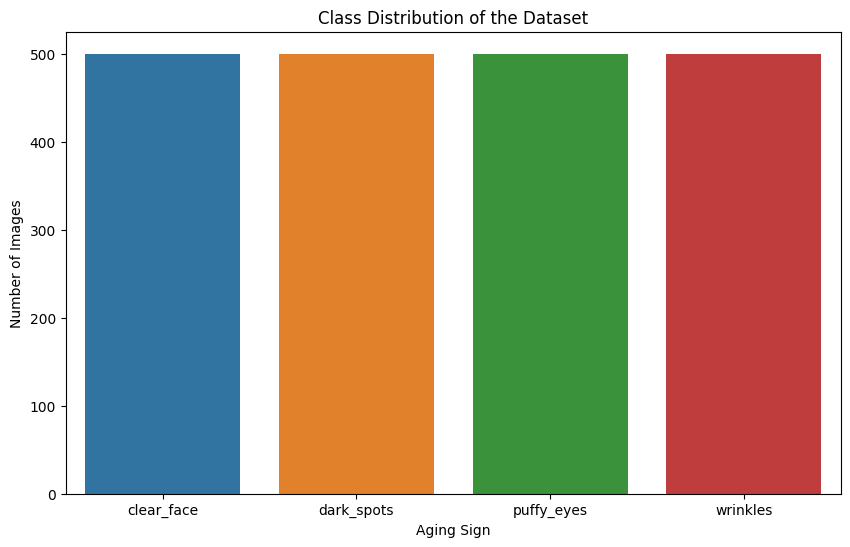

In [3]:
class_counts = {cat: 0 for cat in CATEGORIES}
original_labels = np.argmax(labels, axis=1)
unique, counts = np.unique(original_labels, return_counts=True)
class_distribution = dict(zip([CATEGORIES[i] for i in unique], counts))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.title('Class Distribution of the Dataset')
plt.xlabel('Aging Sign')
plt.ylabel('Number of Images')
plt.show()

## 3. Data Augmentation

In [4]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## 4. Model Building with DenseNet121

In [5]:
# Load the DenseNet121 model with pre-trained ImageNet weights, excluding the top fully connected layer
baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CATEGORIES), activation="softmax")(headModel)

# Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# Freeze all layers in the base DenseNet121 model so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the model
print("Compiling model...")
optimizer = Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.summary()

I0000 00:00:1758033040.324007      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758033040.324642      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 526,852 (2.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 5. Model Training

In [6]:
INIT_EPOCHS = 50
BATCH_SIZE = 32

# Callbacks
checkpoint = ModelCheckpoint('best_densenet_classifier.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(valX, valY),
    validation_steps=len(valX) // BATCH_SIZE,
    epochs=INIT_EPOCHS,
    callbacks=[checkpoint, early_stopping])

Training head...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1758033063.618092     100 service.cc:148] XLA service 0x7aace0001cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758033063.620200     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758033063.620226     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758033066.387009     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/40 ━━━━━━━━━━━━━━━━━━━━ 21:40 33s/step - accuracy: 0.2812 - loss: 1.6226

I0000 00:00:1758033078.512103     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.3137 - loss: 1.4912

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_accuracy improved from -inf to 0.61875, saving model to best_densenet_classifier.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 646ms/step - accuracy: 0.3161 - loss: 1.4862 - val_accuracy: 0.6187 - val_loss: 0.8688
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.6070 - loss: 0.9156
Epoch 2: val_accuracy improved from 0.61875 to 0.73125, saving model to best_densenet_classifier.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 340ms/step - accuracy: 0.6075 - loss: 0.9149 - val_accuracy: 0.7312 - val_loss: 0.6954
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.6982 - loss: 0.7492
Epoch 3: val_accuracy improved from 0.73125 to 0.74687, saving model to best_densenet_classifier.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.6984 - loss: 0.7491 - val_accuracy: 0.7469 - val_loss: 0.6410
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7356 - loss: 0.6578
Epoch 4: val_accuracy improved from 0.74687 to 0.79688, saving model to best_densenet_clas

## 6. Model Evaluation

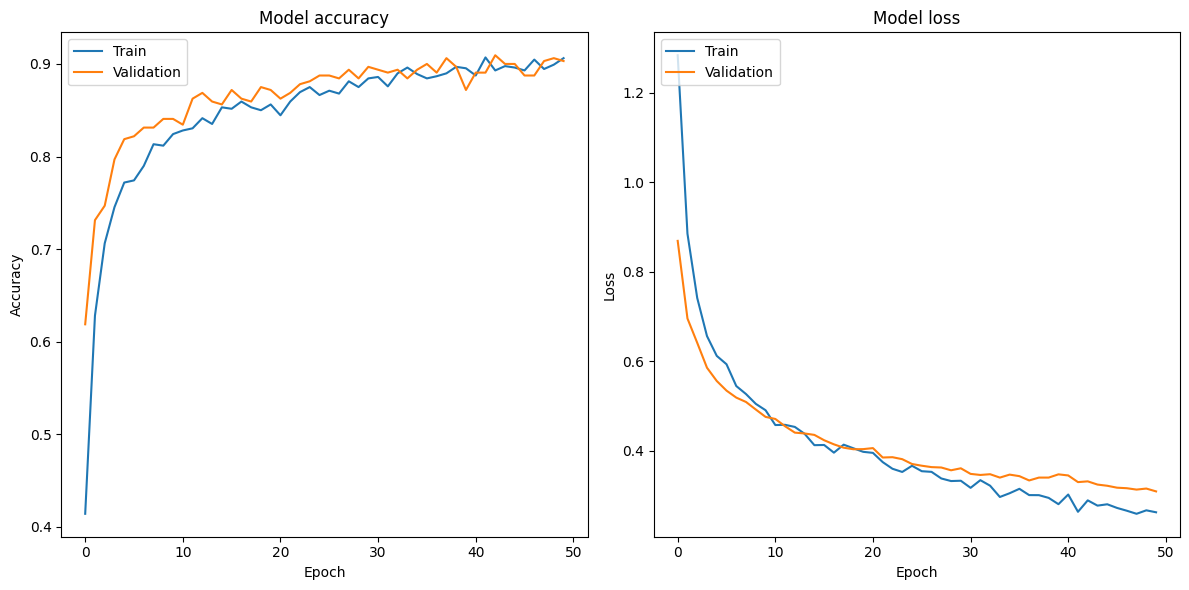

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Evaluating on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 883ms/step - accuracy: 0.8908 - loss: 0.3476
Test loss: 0.3445814251899719
Test accuracy: 0.8774999976158142
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 906ms/step

Classification Report:
              precision    recall  f1-score   support

  clear_face       0.94      0.94      0.94       100
  dark_spots       0.83      0.91      0.87       100
  puffy_eyes       0.86      0.88      0.87       100
    wrinkles       0.89      0.78      0.83       100

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



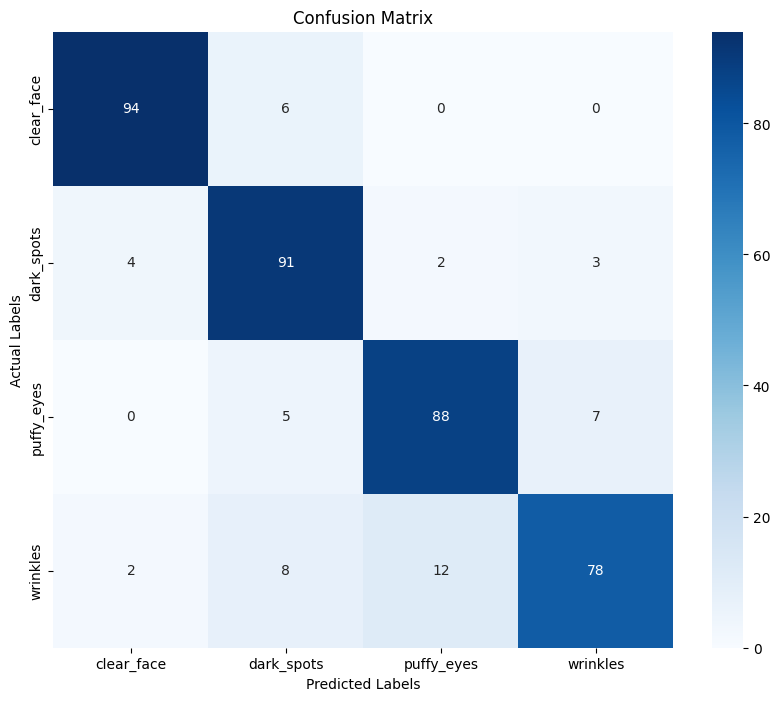

In [8]:
# Load the best model saved by ModelCheckpoint
from tensorflow.keras.models import load_model
best_model = load_model('best_densenet_classifier.h5')

# Evaluate the model on the test set
print("\nEvaluating on test data...")
score = best_model.evaluate(testX, testY, verbose=1)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Generate predictions
predictions = best_model.predict(testX, batch_size=BATCH_SIZE)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(testY, axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=CATEGORIES))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## 7. Fine-Tuning

In [9]:
# Unfreeze some of the top layers of the model
# The number of layers to unfreeze can be tuned. Let's unfreeze the last 50.
for layer in baseModel.layers[-50:]:
    layer.trainable = True

print("Re-compiling model for fine-tuning...")
optimizer_fine_tune = Adam(learning_rate=1e-5) # Use a lower learning rate for fine-tuning
best_model.compile(loss="categorical_crossentropy", optimizer=optimizer_fine_tune, metrics=["accuracy"])

# Callbacks for fine-tuning
checkpoint_ft = ModelCheckpoint('fine_tuned_densenet_classifier.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_ft = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nFine-tuning model...")
FINE_TUNE_EPOCHS = 30
H_ft = best_model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(valX, valY),
    validation_steps=len(valX) // BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[checkpoint_ft, early_stopping_ft])

Re-compiling model for fine-tuning...

Fine-tuning model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8917 - loss: 0.2757
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to fine_tuned_densenet_classifier.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 607ms/step - accuracy: 0.8917 - loss: 0.2760 - val_accuracy: 0.9000 - val_loss: 0.3235
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9009 - loss: 0.3009
Epoch 2: val_accuracy improved from 0.90000 to 0.90312, saving model to fine_tuned_densenet_classifier.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 350ms/step - accuracy: 0.9010 - loss: 0.3002 - val_accuracy: 0.9031 - val_loss: 0.3259
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8826 - loss: 0.2721
Epoch 3: val_accuracy did not improve from 0.90312
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 321ms/step - accuracy: 0.8828 - loss: 0.2721 - val_accuracy: 0.9031 - val_loss: 0.3240
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8917 - loss: 0.2913
Epoch 4: val_accuracy did not improve from

### Evaluate Fine-Tuned Model


Evaluating fine-tuned model on test data...
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 535ms/step - accuracy: 0.8959 - loss: 0.3505
Fine-tuned Test loss: 0.34260720014572144
Fine-tuned Test accuracy: 0.8849999904632568
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 782ms/step

Fine-Tuned Classification Report:
              precision    recall  f1-score   support

  clear_face       0.94      0.94      0.94       100
  dark_spots       0.84      0.92      0.88       100
  puffy_eyes       0.87      0.90      0.88       100
    wrinkles       0.91      0.78      0.84       100

    accuracy                           0.89       400
   macro avg       0.89      0.89      0.88       400
weighted avg       0.89      0.89      0.88       400



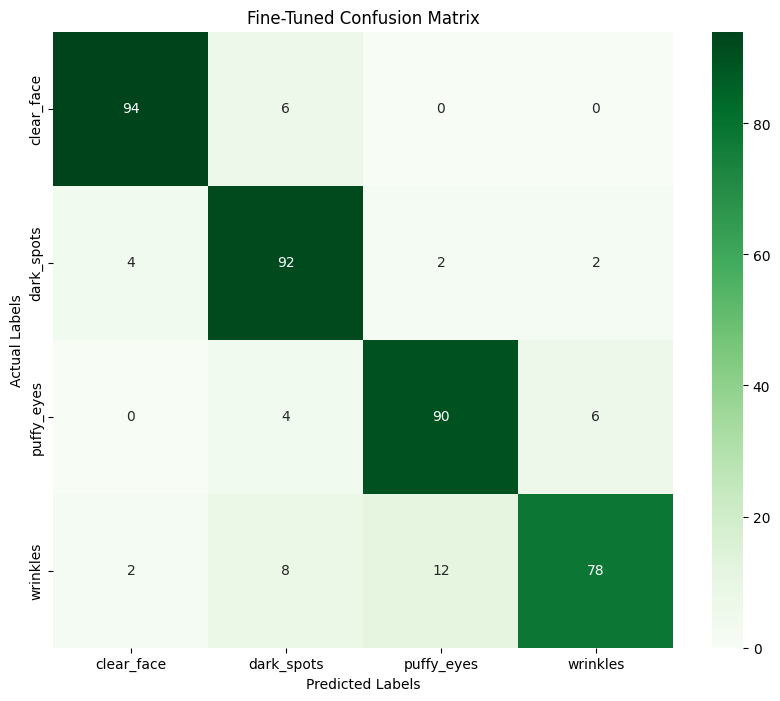

In [10]:
final_model = load_model('fine_tuned_densenet_classifier.h5')

# Evaluate the model on the test set
print("\nEvaluating fine-tuned model on test data...")
score_ft = final_model.evaluate(testX, testY, verbose=1)
print(f"Fine-tuned Test loss: {score_ft[0]}")
print(f"Fine-tuned Test accuracy: {score_ft[1]}")

# Generate predictions
predictions_ft = final_model.predict(testX, batch_size=BATCH_SIZE)
predicted_labels_ft = np.argmax(predictions_ft, axis=1)

# Classification Report
print("\nFine-Tuned Classification Report:")
print(classification_report(true_labels, predicted_labels_ft, target_names=CATEGORIES))

# Confusion Matrix
cm_ft = confusion_matrix(true_labels, predicted_labels_ft)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title('Fine-Tuned Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## 8. Saving the Final Model

In [14]:
# The best fine-tuned model is already saved as 'fine_tuned_densenet_classifier.h5' by the ModelCheckpoint callback.
print("Final model saved as fine_tuned_densenet_classifier.h5")

Final model saved as fine_tuned_densenet_classifier.h5


## Run the below cells only for testing the model inside this notebook.

(NOTE: Don't forget to change the path of the model where you have saved it. Also update the path of the test image)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define constants needed for prediction
IMG_SIZE = (224, 224)
CATEGORIES = ['clear_face', 'dark_spots', 'puffy_eyes', 'wrinkles']

# Load the final trained model
print("Loading final model...")
final_model = load_model(r"C:\\Users\\harsh\\Documents\\DermalScan\\models\\fine_tuned_densenet_classifier.h5")
print("Model loaded successfully!")

Loading final model...


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


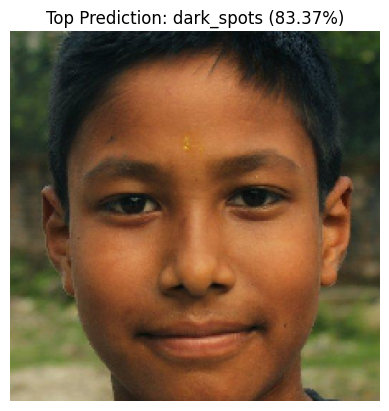

--- Confidence Scores ---
Clear Face: 0.45%
Dark Spots: 83.37%
Puffy Eyes: 5.51%
Wrinkles: 10.67%
-------------------------

Major Aging Feature Found: Dark Spots


In [16]:
# IMPORTANT: Set the path to the image you want to test
image_path_to_test = r'C:\\Users\\harsh\\Documents\\DermalScan\\datasets\\skin_dataset\\dark_spots\\11.jpg' # <-- CHANGE THIS

try:
    # Preprocess the image
    img = load_img(image_path_to_test, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) # Create a batch
    img_array = img_array / 255.0 # Normalize

    # Make prediction
    prediction = final_model.predict(img_array)[0]
    
    # Map predictions to their class names
    confidence_scores = {CATEGORIES[i]: prediction[i] * 100 for i in range(len(CATEGORIES))}
    
    # Determine the winning class
    predicted_class_name = max(confidence_scores, key=confidence_scores.get)

    # --- Display the results ---
    
    # Display the image with the top prediction
    plt.imshow(img)
    plt.title(f'Top Prediction: {predicted_class_name} ({confidence_scores[predicted_class_name]:.2f}%)')
    plt.axis('off')
    plt.show()

    # Print confidence scores for all features
    print("--- Confidence Scores ---")
    for feature, score in confidence_scores.items():
        print(f"{feature.replace('_', ' ').title()}: {score:.2f}%")
    print("-------------------------")

    # Print the final analysis based on the custom logic
    if predicted_class_name in ['puffy_eyes', 'wrinkles', 'dark_spots']:
        print(f"\nMajor Aging Feature Found: {predicted_class_name.replace('_', ' ').title()}")
    else:
        print("\nLittle aging signs found, it is a clear face.")

except FileNotFoundError:
    print(f"Error: The file was not found at {image_path_to_test}")
    print("Please update the 'image_path_to_test' variable with a valid path.")
except Exception as e:
    print(f"An error occurred: {e}")